In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.svm import SVR
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer

# 1) ANALISAR O DATASET

In [14]:
df = pd.read_csv("dataset.csv")
df.sample(4) #Primeira visao do data set

,genero,estado_civil,zona_residencia,imc,fumador,class_etaria,custo
1154,feminino,viuvo,urbana,26.6,nao,adulto_jovem,2319.7
1807,masculino,casado,suburbana,33.6,nao,adulto_senior,5585.2
1157,feminino,casado,urbana,36.7,sim,adulto_senior,20140.7
286,feminino,viuvo,rural,38.3,nao,idoso,6568.4


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2215 entries, 0 to 2214
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   genero           2215 non-null   object 
 1   estado_civil     2215 non-null   object 
 2   zona_residencia  2215 non-null   object 
 3   imc              2215 non-null   float64
 4   fumador          2215 non-null   object 
 5   class_etaria     2215 non-null   object 
 6   custo            2215 non-null   float64
dtypes: float64(2), object(5)
memory usage: 121.3+ KB


In [16]:
df.select_dtypes(include=['object']).describe()

,genero,estado_civil,zona_residencia,fumador,class_etaria
count,2215,2215,2215,2215,2215
unique,2,4,3,2,6
top,masculino,solteiro,urbana,nao,adulto_meia_idade
freq,1127,828,1067,1765,666


In [17]:
df.describe() #Já é possivel imaginar possiveis outliers

,imc,custo
count,2215.000000,2215.000000
mean,30.704199,6045.710971
std,6.425918,8354.316703
min,3.400000,487.200000
25%,26.150000,2042.200000
50%,30.400000,4050.700000
75%,34.700000,7176.300000
max,83.100000,180544.400000


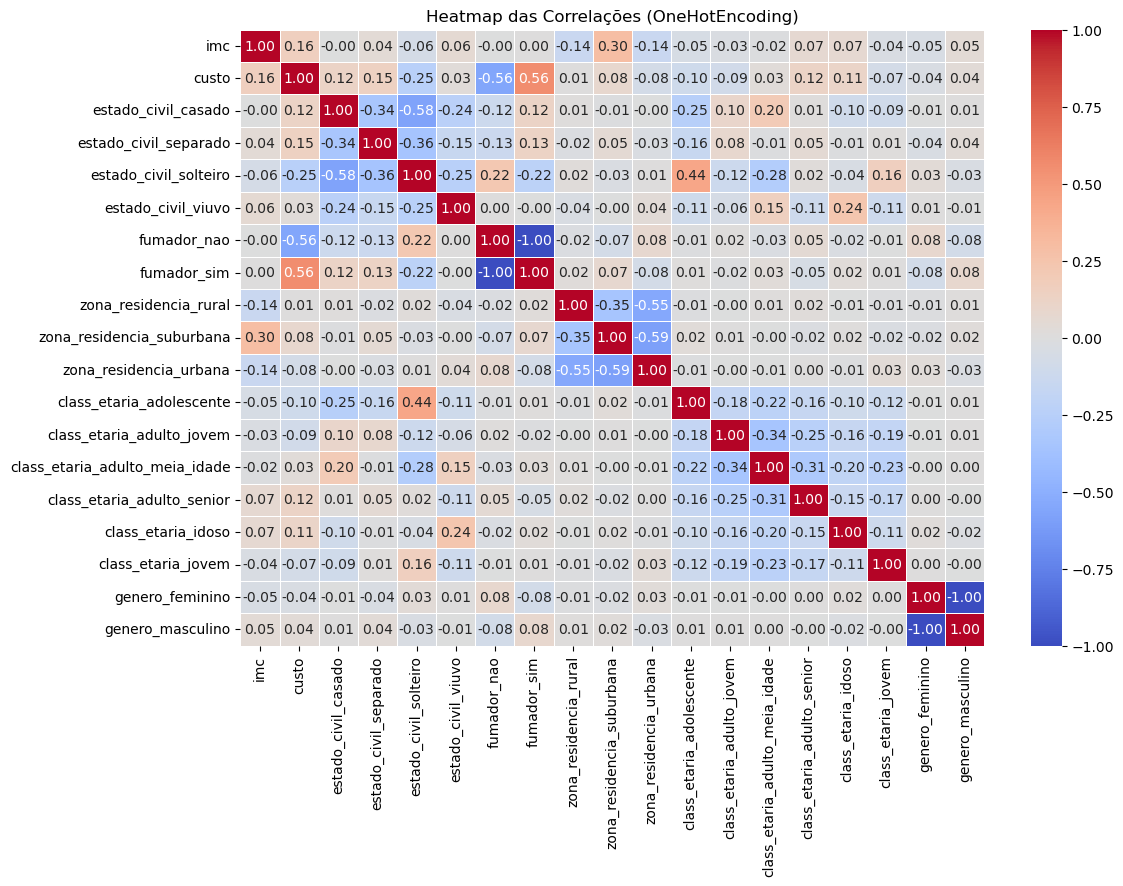

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

# Criar uma cópia do dataframe original
df_new = df.copy()

# Usando OneHotEncoder do scikit-learn com sparse_output=False
encoder = OneHotEncoder(sparse_output=False)

# Variável estado_civil
estado_civil_ohe = encoder.fit_transform(df_new[['estado_civil']])
estado_civil_df = pd.DataFrame(
    estado_civil_ohe,
    columns=[f"estado_civil_{cat}" for cat in encoder.categories_[0]]
)

# Variável fumador
fumador_ohe = encoder.fit_transform(df_new[['fumador']])
fumador_df = pd.DataFrame(
    fumador_ohe,
    columns=[f"fumador_{cat}" for cat in encoder.categories_[0]]
)

# Variável zona_residencia
zona_residencia_ohe = encoder.fit_transform(df_new[['zona_residencia']])
zona_residencia_df = pd.DataFrame(
    zona_residencia_ohe,
    columns=[f"zona_residencia_{cat}" for cat in encoder.categories_[0]]
)

# Variável class_etaria
class_etaria_ohe = encoder.fit_transform(df_new[['class_etaria']])
class_etaria_df = pd.DataFrame(
    class_etaria_ohe,
    columns=[f"class_etaria_{cat}" for cat in encoder.categories_[0]]
)

# Variável genero
genero_ohe = encoder.fit_transform(df_new[['genero']])
genero_df = pd.DataFrame(
    genero_ohe,
    columns=[f"genero_{cat}" for cat in encoder.categories_[0]]
)

# Concatenando os DataFrames gerados com as variáveis originais
df_new = pd.concat(
    [
        df_new.reset_index(drop=True),
        estado_civil_df,
        fumador_df,
        zona_residencia_df,
        class_etaria_df,
        genero_df,
    ],
    axis=1,
)

# Removendo as colunas originais
df_new.drop(['estado_civil', 'fumador', 'zona_residencia', 'class_etaria', 'genero'], axis=1, inplace=True)

# Visualizar o heatmap das correlações entre as variáveis
plt.figure(figsize=(12, 8))
corr = df_new.corr()  # Cálculo da correlação entre as variáveis
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Heatmap das Correlações (OneHotEncoding)')
plt.show()


In [19]:
df_new.corr()

,imc,custo,estado_civil_casado,estado_civil_separado,estado_civil_solteiro,estado_civil_viuvo,fumador_nao,fumador_sim,zona_residencia_rural,zona_residencia_suburbana,zona_residencia_urbana,class_etaria_adolescente,class_etaria_adulto_jovem,class_etaria_adulto_meia_idade,class_etaria_adulto_senior,class_etaria_idoso,class_etaria_jovem,genero_feminino,genero_masculino
imc,1.000000,0.162594,-0.000824,0.039166,-0.063557,0.055681,-0.004857,0.004857,-0.143226,0.295950,-0.141453,-0.046930,-0.027873,-0.015263,0.066997,0.066883,-0.038008,-0.045174,0.045174
custo,0.162594,1.000000,0.117709,0.145642,-0.249289,0.030201,-0.562404,0.562404,0.005306,0.082022,-0.077849,-0.102522,-0.093739,0.031032,0.120443,0.114632,-0.073948,-0.036331,0.036331
estado_civil_casado,-0.000824,0.117709,1.000000,-0.343661,-0.575285,-0.239698,-0.122988,0.122988,0.014850,-0.008877,-0.004820,-0.250363,0.095630,0.196216,0.007980,-0.095394,-0.094907,-0.005741,0.005741
estado_civil_separado,0.039166,0.145642,-0.343661,1.000000,-0.356616,-0.148588,-0.129668,0.129668,-0.015650,0.047959,-0.029415,-0.155199,0.079779,-0.010256,0.049900,-0.011467,0.008528,-0.038153,0.038153
estado_civil_solteiro,-0.063557,-0.249289,-0.575285,-0.356616,1.000000,-0.248734,0.223148,-0.223148,0.020689,-0.026445,0.005863,0.435199,-0.121016,-0.276676,0.020203,-0.042359,0.156333,0.032272,-0.032272
estado_civil_viuvo,0.055681,0.030201,-0.239698,-0.148588,-0.248734,1.000000,0.000990,-0.000990,-0.038287,-0.004119,0.036561,-0.108249,-0.060386,0.150061,-0.111703,0.241868,-0.114569,0.005669,-0.005669
fumador_nao,-0.004857,-0.562404,-0.122988,-0.129668,0.223148,0.000990,1.000000,-1.000000,-0.016988,-0.071060,0.078086,-0.012216,0.015025,-0.031065,0.051985,-0.023901,-0.005020,0.078643,-0.078643
fumador_sim,0.004857,0.562404,0.122988,0.129668,-0.223148,-0.000990,-1.000000,1.000000,0.016988,0.071060,-0.078086,0.012216,-0.015025,0.031065,-0.051985,0.023901,0.005020,-0.078643,0.078643
zona_residencia_rural,-0.143226,0.005306,0.014850,-0.015650,0.020689,-0.038287,-0.016988,0.016988,1.000000,-0.349215,-0.546725,-0.009584,-0.004606,0.009029,0.016182,-0.006437,-0.011964,-0.010007,0.010007
zona_residencia_suburbana,0.295950,0.082022,-0.008877,0.047959,-0.026445,-0.004119,-0.071060,0.071060,-0.349215,1.000000,-0.593673,0.023891,0.007429,-0.000248,-0.017828,0.015133,-0.023883,-0.018484,0.018484


In [20]:
# Separar o target (custo) e as features
X = df_new.drop(columns=['custo'])
y = df_new['custo']

In [21]:
from sklearn.preprocessing import StandardScaler

# Normalizar os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [22]:
from sklearn.model_selection import train_test_split

# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [25]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
# Criar pipeline com normalização e SVM
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR())
])

# Definir os hiperparâmetros para ajuste
param_grid = {
    'svr__kernel': ['linear', 'rbf', 'poly'],
    'svr__C': [0.1, 1, 10, 100],
    'svr__epsilon': [0.1, 0.2, 0.5, 1]
}

# Ajustar os hiperparâmetros com GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=3)
grid_search.fit(X_train, y_train)

# Melhor modelo encontrado
best_model = grid_search.best_estimator_

print(f"Melhores parâmetros: {grid_search.best_params_}")

# Avaliar no conjunto de teste
y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (SVM): {mse}")
print(f"R2 Score (SVM): {r2}")

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5] END svr__C=0.1, svr__epsilon=0.1, svr__kernel=linear;, score=-31046997.230 total time=   0.0s
[CV 2/5] END svr__C=0.1, svr__epsilon=0.1, svr__kernel=linear;, score=-72475872.784 total time=   0.0s
[CV 3/5] END svr__C=0.1, svr__epsilon=0.1, svr__kernel=linear;, score=-51009307.783 total time=   0.0s
[CV 4/5] END svr__C=0.1, svr__epsilon=0.1, svr__kernel=linear;, score=-127009729.359 total time=   0.0s
[CV 5/5] END svr__C=0.1, svr__epsilon=0.1, svr__kernel=linear;, score=-24253866.811 total time=   0.0s
[CV 1/5] END svr__C=0.1, svr__epsilon=0.1, svr__kernel=rbf;, score=-32784950.374 total time=   0.1s
[CV 2/5] END svr__C=0.1, svr__epsilon=0.1, svr__kernel=rbf;, score=-74426063.688 total time=   0.1s
[CV 3/5] END svr__C=0.1, svr__epsilon=0.1, svr__kernel=rbf;, score=-53022837.723 total time=   0.1s
[CV 4/5] END svr__C=0.1, svr__epsilon=0.1, svr__kernel=rbf;, score=-129036092.730 total time=   0.1s
[CV 5/5] END svr__C=0

In [24]:
# Prever no conjunto de teste
y_pred_svr = best_svr.predict(X_test)

# Avaliar o modelo
mse_svr = mean_squared_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)

print(f"Mean Squared Error (SVM): {mse_svr}")
print(f"R2 Score (SVM): {r2_svr}")

Mean Squared Error (SVM): 79618570.21851823
R2 Score (SVM): 0.2810314805406665


In [273]:
from sklearn.preprocessing import LabelEncoder
#estado civil
df_new = df.copy()

le = LabelEncoder()
le.fit(df_new.estado_civil.drop_duplicates()) 
df_new.estado_civil = le.transform(df_new.estado_civil)
# fumador
le.fit(df_new.fumador.drop_duplicates()) 
df_new.fumador = le.transform(df_new.fumador)
# regiao
le.fit(df_new.zona_residencia.drop_duplicates()) 
df_new.zona_residencia = le.transform(df_new.zona_residencia)
# class_etaria	
le.fit(df_new.class_etaria.drop_duplicates()) 
df_new.class_etaria = le.transform(df_new.class_etaria)
#genero
le.fit(df_new.genero.drop_duplicates()) 
df_new.genero = le.transform(df_new.genero)

In [274]:
print(df_new)

      genero  estado_civil  zona_residencia   imc  fumador  class_etaria  \
0          1             0                1  35.8        1             2   
1          0             1                2  39.3        0             3   
2          1             2                0  40.7        0             5   
3          1             0                2  28.2        1             2   
4          0             2                2  31.1        0             3   
...      ...           ...              ...   ...      ...           ...   
2210       0             2                1  35.4        0             3   
2211       0             2                0  29.9        0             3   
2212       0             2                0  26.1        0             1   
2213       0             2                2  27.7        0             1   
2214       1             2                2  28.7        0             3   

        custo  
0     18213.9  
1      4266.4  
2       854.6  
3     10169.7  
4      

In [275]:
df_new.describe()

,genero,estado_civil,zona_residencia,imc,fumador,class_etaria,custo
count,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000
mean,0.508804,1.204966,1.238375,30.704199,0.203160,2.272686,6045.710971
std,0.500035,1.031777,0.817640,6.425918,0.402442,1.445689,8354.316703
min,0.000000,0.000000,0.000000,3.400000,0.000000,0.000000,487.200000
25%,0.000000,0.000000,1.000000,26.150000,0.000000,1.000000,2042.200000
50%,1.000000,1.000000,1.000000,30.400000,0.000000,2.000000,4050.700000
75%,1.000000,2.000000,2.000000,34.700000,0.000000,3.000000,7176.300000
max,1.000000,3.000000,2.000000,83.100000,1.000000,5.000000,180544.400000


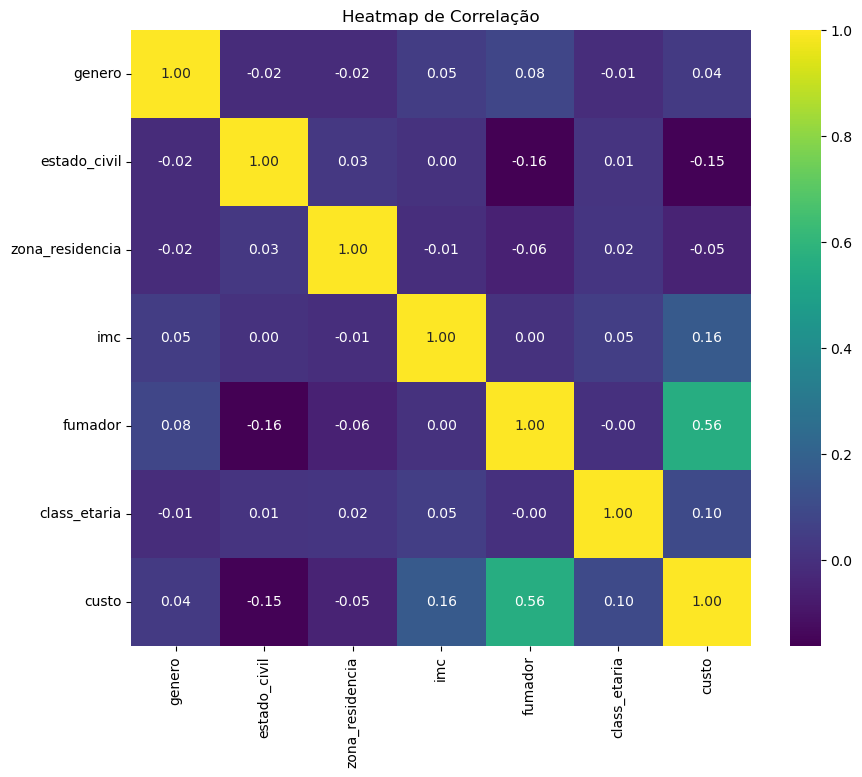

In [276]:
import seaborn as sns
import matplotlib.pyplot as plt

# Heatmap de correlação
corr_matrix = df_new.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="viridis", cbar=True)
plt.title("Heatmap de Correlação")
plt.show()

In [277]:
df.select_dtypes(include=['object']).describe()

,genero,estado_civil,zona_residencia,fumador,class_etaria
count,2215,2215,2215,2215,2215
unique,2,4,3,2,6
top,masculino,solteiro,urbana,nao,adulto_meia_idade
freq,1127,828,1067,1765,666


In [278]:
cat=df.select_dtypes(include=['object']).columns.tolist()
for i in cat:
    obs=df[i].value_counts()
    avg_claim=df.groupby(i)["custo"].mean()
    display(pd.DataFrame({"Number of Policyholders":obs, "Average Claim Amount":avg_claim.map('${:,.2f}'.format)})\
            .sort_values('Number of Policyholders', ascending=False)\
            .style.set_caption("Variable: {}".format(i)))

,Number of Policyholders,Average Claim Amount
genero,,
masculino,1127,"$6,343.87"
feminino,1088,"$5,736.87"


,Number of Policyholders,Average Claim Amount
estado_civil,,
solteiro,828,"$3,350.83"
casado,790,"$7,366.14"
separado,389,"$8,681.29"
viuvo,208,"$6,829.28"


,Number of Policyholders,Average Claim Amount
zona_residencia,,
urbana,1067,"$5,371.25"
suburbana,609,"$7,158.24"
rural,539,"$6,123.86"


,Number of Policyholders,Average Claim Amount
fumador,,
nao,1765,"$3,673.82"
sim,450,"$15,348.80"


,Number of Policyholders,Average Claim Amount
class_etaria,,
adulto_meia_idade,666,"$6,441.00"
adulto_jovem,480,"$4,557.17"
adulto_senior,403,"$8,178.87"
jovem,249,"$4,310.18"
adolescente,225,"$3,499.09"
idoso,192,"$9,153.59"


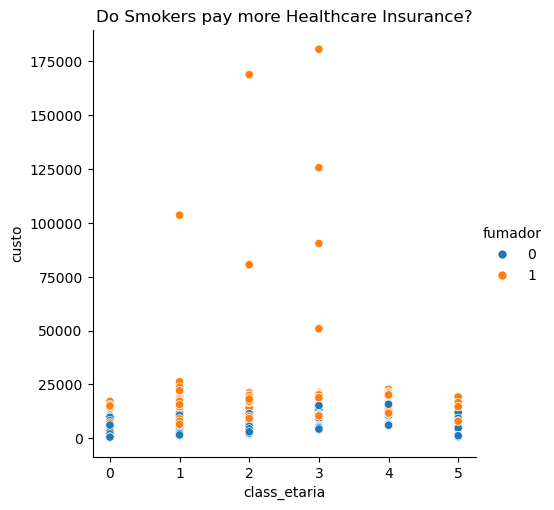

In [279]:
sns.relplot(x='class_etaria', y='custo', data=df_new, hue='fumador')  # Color by smoker

# Add labels and title
plt.xlabel("class_etaria")
plt.ylabel("custo")
plt.title("Do Smokers pay more Healthcare Insurance?")
plt.show()

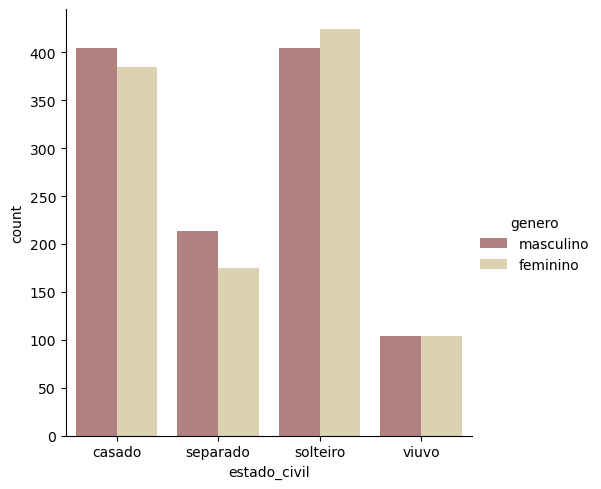

In [280]:
sns.catplot(x="estado_civil", kind="count",hue = 'genero', palette="pink", data=df)

In [281]:
df.sample(2)

,genero,estado_civil,zona_residencia,imc,fumador,class_etaria,custo
571,feminino,solteiro,suburbana,33.8,nao,adolescente,4951.4
939,feminino,solteiro,urbana,33.0,nao,adulto_meia_idade,2840.0


<Axes: xlabel='imc', ylabel='custo'>

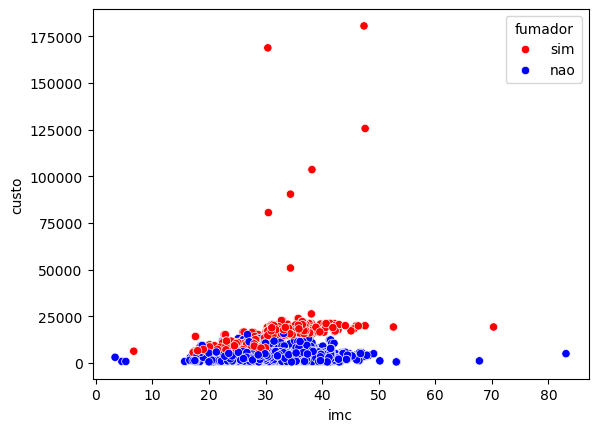

In [282]:
sns.scatterplot(data=df,x='imc',y='custo',hue='fumador',palette=['r','b'])
#Claramente fumadores gastam mais dinheiro em seguros de saude, o imc alto ou baixo desde que nao fume nao tem grande importancia no custo

# 2)Pré-processamento

In [283]:
print(df.isnull().sum())  # Verificar valores nulos
df.drop_duplicates(keep='first',inplace=True) #Eliminar valores duplicados caso existam

genero             0
estado_civil       0
zona_residencia    0
imc                0
fumador            0
class_etaria       0
custo              0
dtype: int64


# Analisar possiveis outliers

<Axes: ylabel='imc'>

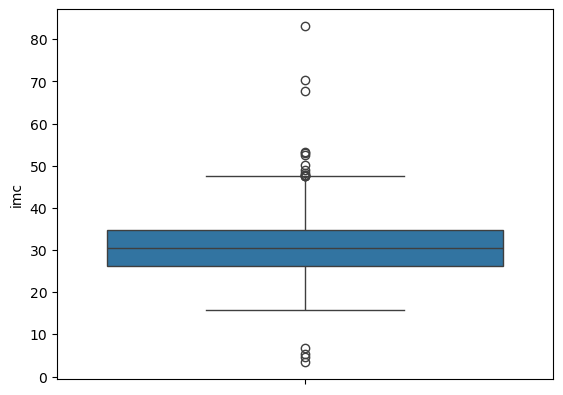

In [284]:
import seaborn as sns
sns.boxplot(data=df['imc'])

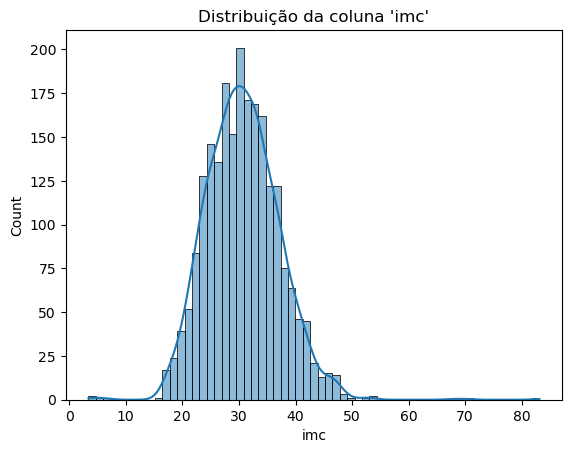

In [285]:
sns.histplot(df['imc'], kde=True)
plt.title("Distribuição da coluna 'imc'")
plt.show()

Apesar de quando se um grafico com distribuiçao normal se usar tipicamente o z-score, constatou-se que o Tukey Fence apresenta menos outliers, por isso será o metodo aplicado

In [286]:
# Calcular os quartis Q1 e Q3 para 'imc'
Q1_imc = df['imc'].quantile(0.25)
Q3_imc = df['imc'].quantile(0.75)

# Calcular o IQR (intervalo interquartil) para 'imc'
IQR_imc = Q3_imc - Q1_imc

# Fatores para os limites de Tukey Fences
fator_1_5 = 1.5  # Limites moderados (padrão)

# Limites de Tukey Fences para 'imc'
limite_inferior_tukey_1_5_imc = Q1_imc - fator_1_5 * IQR_imc
limite_superior_tukey_1_5_imc = Q3_imc + fator_1_5 * IQR_imc

# Exibir os limites calculados
print("Limite inferior (1.5 * IQR) para 'imc': ", limite_inferior_tukey_1_5_imc)
print("Limite superior (1.5 * IQR) para 'imc': ", limite_superior_tukey_1_5_imc)

Limite inferior (1.5 * IQR) para 'imc':  13.262499999999996
Limite superior (1.5 * IQR) para 'imc':  47.56250000000001


In [287]:
# outliers no 'imc'
outliers_imc = df[(df['imc'] < limite_inferior_tukey_1_5_imc) | (df['imc'] > limite_superior_tukey_1_5_imc)]

print("Quantidade eliminada de outliers em 'imc': ",outliers_imc.shape[0])
print(outliers_imc[['imc']])  # Exibe os primeiros valores eliminados

Quantidade eliminada de outliers em 'imc':  18
       imc
320   67.8
355    4.6
564   47.7
711   47.6
727   83.1
755   50.2
762   53.2
936   48.3
1059   5.3
1083  47.6
1378  52.6
1494   6.7
1611  49.1
1739  47.9
1773  70.3
1823   3.4
2049  47.6
2092  53.1


In [288]:
# Filtrando o DataFrame para remover os outliers com base nos limites de Tukey Fences
df = df[(df['imc'] >= limite_inferior_tukey_1_5_imc) & (df['imc'] <= limite_superior_tukey_1_5_imc)]
df.sample(2)

,genero,estado_civil,zona_residencia,imc,fumador,class_etaria,custo
1250,masculino,separado,urbana,30.9,sim,adulto_meia_idade,17150.2
2152,masculino,separado,urbana,29.3,nao,adulto_senior,4503.8


<Axes: ylabel='imc'>

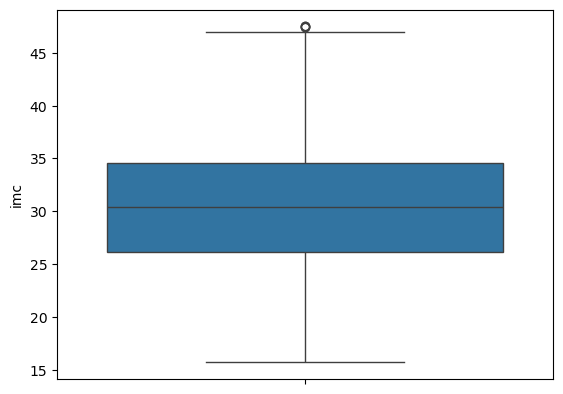

In [289]:
import seaborn as sns
sns.boxplot(data=df['imc']) #Hum temos claramente muitos valores discrepantes (Outliers)
#mediana ou 2ºQuartil no valor 30
#Video para entender o boxplot https://www.youtube.com/watch?v=qU2lANG4hYQ

Resultado pos z-score (Nao usar)

<Axes: ylabel='imc'>

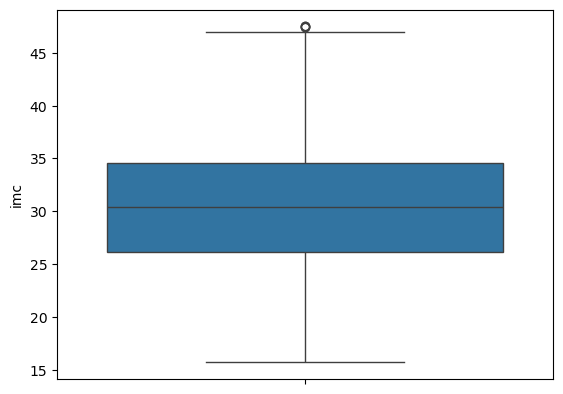

In [290]:
sns.boxplot(data=df['imc'])

#Pos tratamento dos dados da columa imc

CUSTO

In [291]:
df.describe()

,imc,custo
count,2196.000000,2196.000000
mean,30.599590,5995.441803
std,6.002649,7971.361892
min,15.700000,487.200000
25%,26.100000,2049.875000
50%,30.400000,4049.850000
75%,34.600000,7193.775000
max,47.500000,180544.400000


<Axes: ylabel='custo'>

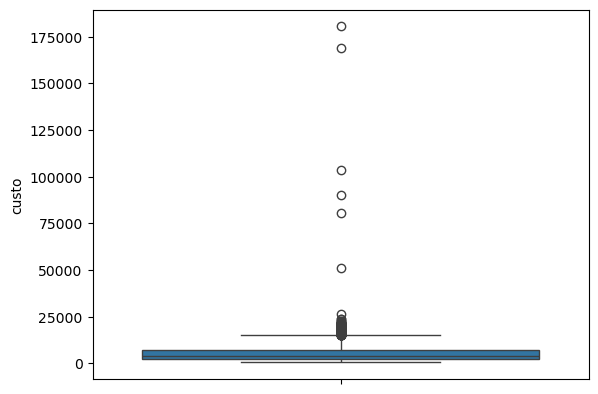

In [292]:
sns.boxplot(data=df['custo'])

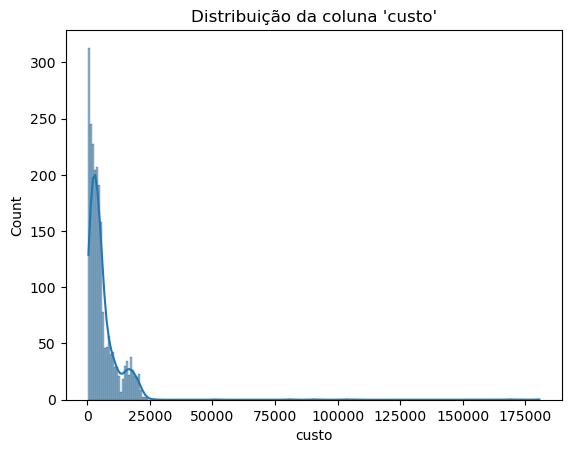

In [293]:
sns.histplot(df['custo'], kde=True)
plt.title("Distribuição da coluna 'custo'")
plt.show()

#Nao Segue uma distribuiçao normal, então usamos o Tukey Fences

In [294]:
Q1 = df['custo'].quantile(0.25)
Q3 = df['custo'].quantile(0.75)

IQR = Q3 - Q1

fator_1_5 = 1.5

limite_inferior_tukey_1_5 = Q1 - fator_1_5 * IQR
limite_superior_tukey_1_5 = Q3 + fator_1_5 * IQR

# Exibir os novos limites
print(f"Limite inferior (1.5 * IQR): {limite_inferior_tukey_1_5}")
print(f"Limite superior (1.5 * IQR): {limite_superior_tukey_1_5}")

Limite inferior (1.5 * IQR): -5665.974999999999
Limite superior (1.5 * IQR): 14909.625


In [295]:
# Filtrar os valores dentro dos limites de Tukey
df = df[(df['custo'] >= limite_inferior_tukey_1_5) & (df['custo'] <= limite_superior_tukey_1_5)]

df_ordenado = df.sort_values(by='custo', ascending=False)
print(df_ordenado['custo'].head(15)) # Confirma-se a eliminaçao dos valores mais altos

835     14880.6
103     14866.6
2034    14864.5
2037    14809.4
1403    14801.2
1954    14788.5
1695    14780.2
393     14746.1
2086    14741.0
2124    14639.0
1489    14634.9
263     14634.3
1405    14632.3
555     14569.7
1170    14561.1
Name: custo, dtype: float64


<Axes: ylabel='custo'>

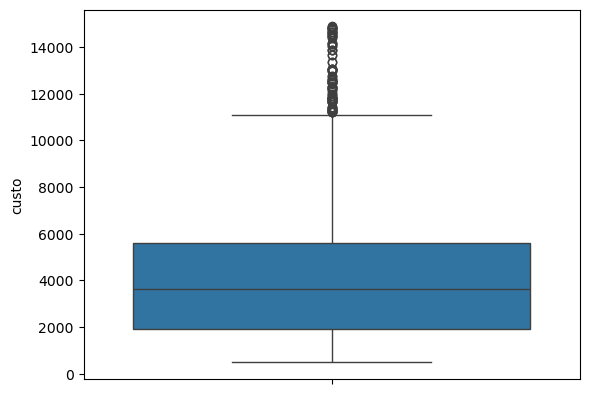

In [296]:
import seaborn as sns
sns.boxplot(data=df['custo']) #Hum temos claramente muitos valores discrepantes (Outliers)
#mediana ou 2ºQuartil no valor 30
#Video para entender o boxplot https://www.youtube.com/watch?v=qU2lANG4hYQ

In [297]:
df.shape

(1969, 7)

Ainda temos os outliers mas menos. Evitamos outliers extremos que é o pretendido para SVM

#FIM

In [298]:
#df['fumador'].value_counts()

Parece que temos dados desbalanceados

In [299]:
#sns.countplot(x='fumador', data=df, palette='Set2')
#plt.title('Distribuição de Fumadores')
#plt.ylabel('Frequência')
#plt.xlabel('Fumador')

Nao me lembro de ser dado em aula, mas posso aplicar

In [300]:
#from sklearn.utils import resample

# Separar classes
#df_minoritario = df[df['fumador'] == 'sim']
#df_majoritario = df[df['fumador'] == 'nao']

# Ampliar classe minoritária
#df_minoritario_oversampled = resample(df_minoritario, 
#                                      replace=True, 
#                                      n_samples=len(df_majoritario), 
#                                     random_state=12)

# Combinar as classes novamente
#df = pd.concat([df_majoritario, df_minoritario_oversampled])

# Conferir distribuição
#print(df['fumador'].value_counts())

In [301]:
#sns.countplot(x='fumador', data=df, palette='Set2')
#plt.title('Distribuição de Fumadores')
#plt.ylabel('Frequência')
#plt.xlabel('Fumador')

#INICIO2

In [302]:
df['genero'] = df['genero'].map({'masculino': 1, 'feminino': 0})
df['fumador'] = df['fumador'].map({'sim': 1, 'nao': 0})
df

,genero,estado_civil,zona_residencia,imc,fumador,class_etaria,custo
1,0,separado,urbana,39.3,0,adulto_senior,4266.4
2,1,solteiro,rural,40.7,0,jovem,854.6
3,1,casado,urbana,28.2,1,adulto_meia_idade,10169.7
4,0,solteiro,urbana,31.1,0,adulto_senior,4151.5
5,1,separado,rural,30.6,1,jovem,14446.9
...,...,...,...,...,...,...,...
2210,0,solteiro,suburbana,35.4,0,adulto_senior,5283.3
2211,0,solteiro,rural,29.9,0,adulto_senior,4867.4
2212,0,solteiro,rural,26.1,0,adulto_jovem,2261.2
2213,0,solteiro,urbana,27.7,0,adulto_jovem,1536.3


In [303]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False) #Deixa no formato matriz em vez de array2D
ohe = encoder.fit_transform(df[['estado_civil','zona_residencia','class_etaria']])
print(ohe[0]) #Espera-se 4+3+6 valores

[0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.]


In [304]:
df.drop(['estado_civil', 'zona_residencia', 'class_etaria'], axis=1, inplace=True) #Eliminar as colunas 

<Axes: >

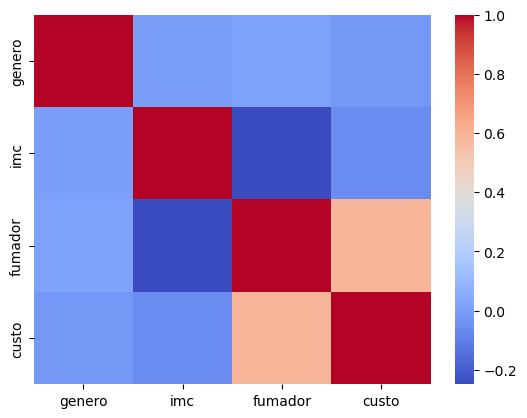

In [305]:
sns.heatmap(df.corr(),cmap='coolwarm')

In [306]:
X = df.drop('custo',axis=1) # Apenas Features 
X = np.c_[X, ohe] # Junta as variaveis do OHE
y = df['custo'] # Apenas o target
print(X[0]) #Vemos as variaveis (Genero, IMC, Fumador, 4 para estado_civil, 3 para zona_residencia e 6 para class_etaria)

[ 0.  39.3  0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   1.
  0.   0. ]


<Axes: >

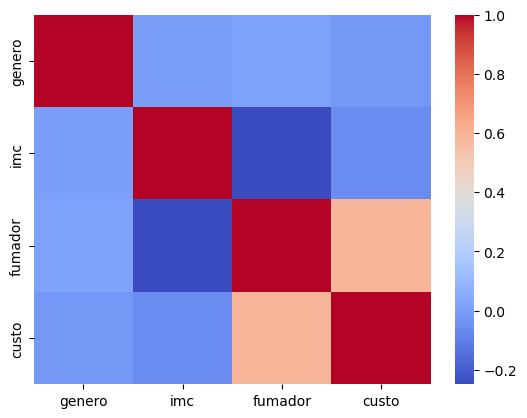

In [307]:
sns.heatmap(df.corr(),cmap='coolwarm')

In [308]:
correlacao = df.corr()

# Exibir a correlação das variáveis com o custo
correlacao_com_custo = correlacao['custo'].sort_values()

# Exibir os resultados
print(correlacao_com_custo)

imc       -0.060073
genero    -0.023173
fumador    0.592002
custo      1.000000
Name: custo, dtype: float64


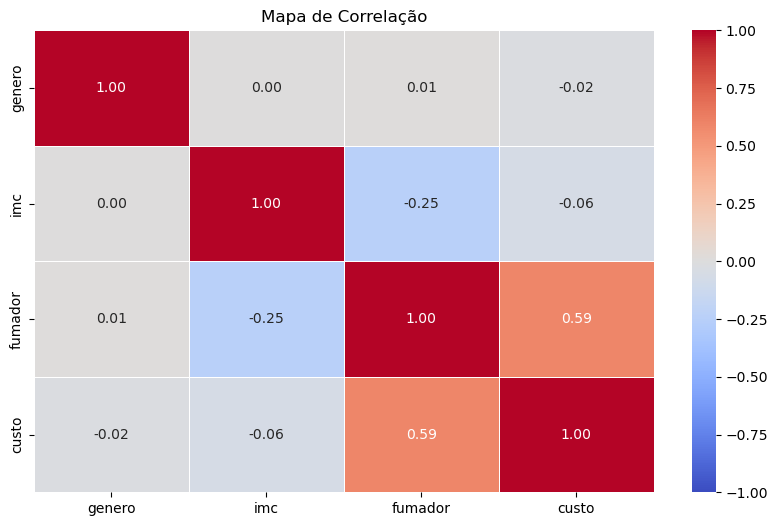

In [309]:
correlacao = df.corr()

# Criar o heatmap
plt.figure(figsize=(10, 6))  # Ajustar o tamanho do gráfico
sns.heatmap(correlacao, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5,vmax=1,vmin=-1)

# Título do heatmap
plt.title("Mapa de Correlação")
plt.show()

Existe uma relação positiva moderada/forte entre ser fumante e o custo. Faz sentido, pois fumar pode estar associado a maiores custos de saúde.

In [310]:
from sklearn.model_selection import train_test_split
Xtreino,Xteste,ytreino,yteste = train_test_split(X,y,test_size=0.2,random_state=12)

Primeiro Modelo Pre Normalizaçao

In [311]:
modelo = SVR()
modelo.fit(Xtreino, ytreino) 
modelo.score(Xteste,yteste)

-0.06500155113501682

In [312]:
Xtreino

array([[ 1. , 30.3,  0. , ...,  1. ,  0. ,  0. ],
       [ 1. , 27.7,  0. , ...,  0. ,  0. ,  0. ],
       [ 1. , 31.8,  0. , ...,  0. ,  0. ,  1. ],
       ...,
       [ 0. , 24. ,  0. , ...,  1. ,  0. ,  0. ],
       [ 1. , 24.4,  0. , ...,  0. ,  0. ,  0. ],
       [ 0. , 44.5,  0. , ...,  0. ,  0. ,  0. ]])

#Normalização das features

In [313]:
# Normalizar as variáveis de entrada e o target
scalerX = StandardScaler()  # Para X
scalery = StandardScaler()  # Para y

# Ajuste do scaler aos dados de treino
scalerX.fit(Xtreino)  
scalery.fit(ytreino.values.reshape(-1, 1))  # reshape para garantir a forma correta

# Transformação dos dados de treino e teste
Xtreino_normalizado = scalerX.transform(Xtreino)
Xteste_normalizado = scalerX.transform(Xteste)
ytreino_normalizado = scalery.transform(ytreino.values.reshape(-1, 1))
yteste_normalizado = scalery.transform(yteste.values.reshape(-1, 1))

Primeiro Modelo pos normalizaçao

In [314]:
modelo = SVR()
modelo.fit(Xtreino_normalizado, ytreino_normalizado.ravel())  # .ravel() para converter y em vetor 1D

SVR()

In [315]:
y_pred_normalizado = modelo.predict(Xteste_normalizado)
y_pred_normalizado

array([-0.83640098, -0.08922041,  0.30721778, -0.56865817,  1.39343023,
       -0.48136851, -0.14321171,  1.4302708 ,  0.10680987, -0.93333429,
        0.10821222,  0.19758712, -0.95195044, -0.03096793,  0.54686817,
        0.8814481 ,  0.25361069, -0.11361487,  1.44214523, -0.58806781,
       -0.08421006, -0.615703  ,  1.3493584 ,  0.30255046,  0.22134041,
       -1.08954452, -0.29718392, -0.81825069, -0.60363189,  0.16331949,
       -0.11178147, -0.25683555,  2.11186176, -0.42375143,  0.49214511,
        0.48693385, -0.50508431,  0.26273175, -0.97034717, -0.90914231,
       -0.27261532, -0.10511359, -1.08128958, -1.02664212, -0.11352449,
       -0.01263822, -0.61654739, -0.61272996,  0.47751854, -0.03584901,
       -0.33979256,  0.52835408, -0.18864806, -0.95502852,  0.40380148,
       -0.08894154, -0.81118858,  0.12539186, -0.43793897,  0.21876773,
       -0.10996413, -0.28702352, -0.35523895, -0.38573464, -1.00377537,
       -0.8690631 ,  1.61580781,  0.21377604, -1.00512061, -0.34

In [316]:
modelo.score(Xteste_normalizado,yteste_normalizado)

0.6407298665122954

Com Afinaçoes

In [317]:
from sklearn.model_selection import GridSearchCV

In [318]:
grelha={'C':[100,10,1,0.1],'gamma':['auto','scale',0.01,1],'kernel':['rbf','sigmoid','linear']}

In [319]:
procura_modelo = GridSearchCV(modelo, param_grid=grelha,cv=10)

In [320]:
procura_modelo.fit(Xtreino_normalizado,ytreino_normalizado.ravel())

GridSearchCV(cv=10, estimator=SVR(),
             param_grid={'C': [100, 10, 1, 0.1],
                         'gamma': ['auto', 'scale', 0.01, 1],
                         'kernel': ['rbf', 'sigmoid', 'linear']})

In [321]:
procura_modelo.best_params_

{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}

In [322]:
modelo_otimo=procura_modelo.best_estimator_

In [323]:
modelo_otimo.score(Xteste_normalizado,yteste_normalizado)

0.6463776238968262